In [ ]:
def reb_plot(data, exp, ax):
    sns.boxplot(
                data=data.expmt(exp).prb('NNXr'), 
                x='store', y='Bandpower', 
                order=['NNXr', 'NNXo'], 
                palette=['lightgray', 'dodgerblue'], 
                fliersize=0, 
                ax=ax, 
                width=0.4,
                medianprops={"color": "#3b3030", "linewidth": 3.2},
                whiskerprops={"color": "#3b3030", "linewidth": 3.2},
                capprops={"color": "#3b3030", "linewidth": 3.2},
                boxprops={"edgecolor": "#3b3030", "linewidth": 3.2},)

    sns.boxplot(
                data=data.expmt(exp).prb('NNXo'), 
                x='store', y='Bandpower', 
                order=['NNXr', 'NNXo'], 
                palette=['lightgray', 'dodgerblue'], 
                fliersize=0, 
                ax=ax, 
                width=0.4,
                medianprops={"color": "#2042d9", "linewidth": 3.2},
                whiskerprops={"color": "#2042d9", "linewidth": 3.2},
                capprops={"color": "#2042d9", "linewidth": 3.2},
                boxprops={"edgecolor": "#2042d9", "linewidth": 3.2},)

    plt.tight_layout()
    for patch in ax.patches:
        r, g, b, a = patch.get_facecolor()
        patch.set_facecolor((r, g, b, 0.6))

    #sns.swarmplot(data=som_swa.expmt('swisin'), x='store', y='Bandpower', order=['NNXr', 'NNXo'], palette=['#202223', 'blue'], marker='o', size=15, ax=ax, alpha=0.4)
    sns.lineplot(data=data.expmt(exp).sort_values('store', ascending=False), x='store', y='Bandpower', units='subject', estimator=None, color='#7800c2', ax=ax, linewidth=4.5, alpha=0.6)
    return ax

# SWA Differences - SWI + SWISIN Experiments

In [1]:
#-------------------------- Standard Imports --------------------------#
%reload_ext autoreload
%autoreload 2
import kdephys as kde
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import acr
plt.style.use('fast')
plt.style.use('/home/kdriessen/gh_master/kdephys/kdephys/plot/acr_plots.mplstyle')

# ---------------------------- EXTRAS --------------------------------#
from acr.utils import swi_subs_exps, sub_probe_locations, sub_exp_types
import pingouin as pg
band_def = list(kde.utils.spectral.bands.keys())

/home/kdriessen/miniconda3/envs/offdet/lib/python3.10/site-packages/neurodsp/__init__.py:5: FutureWarning: neurodsp has been renamed to ibldsp and the old name will be deprecated on 01-Sep-2024.
  warn(


In [2]:
# IMPORTANT PARAMETERS
# --------------------
REBOUND_LENGTH = '1h'
REL_STATE = 'NREM'

# SWA differences during Rebound

In [3]:
reb_df = acr.io.read_full_df(folder='rebound_data_1h')
reb_df = reb_df.sort_values('subject')

## SWA

### ACR

In [22]:
def add_channel_zones(df):
    df['zone'] = 'no_zone'
    df.loc[np.logical_and(df['channel']>0, df['channel']<=4), 'zone'] = 'chans_1-4'
    df.loc[np.logical_and(df['channel']>4, df['channel']<=8), 'zone'] = 'chans_5-8'
    df.loc[np.logical_and(df['channel']>8, df['channel']<=12), 'zone'] = 'chans_9-12'
    df.loc[np.logical_and(df['channel']>12, df['channel']<=16), 'zone'] = 'chans_13-16'
    return df

In [4]:
# Gets the mean DELTA values for the ACR animals, during NREM only, and then renames all experiments to 'swi' so that we can group by subject
delta_acr = reb_df.loc[reb_df['Band']=='delta'].loc[reb_df['state']=='NREM'].loc[reb_df['exp_type']=='acr']
delta_acr_means = delta_acr.groupby(['subject', 'exp', 'store'])['Bandpower'].mean().to_frame().reset_index().sort_values('Bandpower')
acr_swa = delta_acr_means.exp_names()

In [40]:
delta_acr_zones = add_channel_zones(delta_acr)
_acr_swa_zones = delta_acr_zones.groupby(['subject', 'exp', 'store', 'zone'])['Bandpower'].mean().to_frame().reset_index().sort_values('Bandpower')
acr_swa_zones = _acr_swa_zones.exp_names()

In [6]:
# Statistical tests
# -----------------
# Performs statistical tests to determine if the differences between NNXr and NNXo are significant for each experiment.
delta_reb_swi_nnxr = acr_swa.prb('NNXr').expmt('swi').sort_values('subject')['Bandpower'].to_numpy()
delta_reb_swi_nnxo = acr_swa.prb('NNXo').expmt('swi').sort_values('subject')['Bandpower'].to_numpy()

delta_reb_swisin_nnxr = acr_swa.prb('NNXr').expmt('swisin').sort_values('subject')['Bandpower'].to_numpy()
delta_reb_swisin_nnxo = acr_swa.prb('NNXo').expmt('swisin').sort_values('subject')['Bandpower'].to_numpy()

swi_stats = pg.ttest(delta_reb_swi_nnxr, delta_reb_swi_nnxo, paired=True)
swisin_stats = pg.ttest(delta_reb_swisin_nnxr, delta_reb_swisin_nnxo, paired=True)

swi_pval = round(swi_stats['p-val'][0], 5)
swisin_pval = round(swisin_stats['p-val'][0], 5)
print(f'swi p-value = {swi_pval}')
print(f'swisin p-value = {swisin_pval}')

swi p-value = 0.00205
swisin p-value = 0.02495


In [7]:
# Relative statistics (SWI vs. SWISIN)
# This is not super useful/important (as of 2/21/24)
swi_rels = {}
for subject in acr_swa.expmt('swi')['subject'].unique():
    swa_rel = acr_swa.loc[acr_swa['subject']==subject].expmt('swi').prb('NNXo')['Bandpower'].values[0] / acr_swa.loc[acr_swa['subject']==subject].expmt('swi').prb('NNXr')['Bandpower'].values[0]
    swi_rels[subject] = swa_rel
swisin_rels = {}
for subject in acr_swa.expmt('swisin')['subject'].unique():
    swa_rel = acr_swa.loc[acr_swa['subject']==subject].expmt('swisin').prb('NNXo')['Bandpower'].values[0] / acr_swa.loc[acr_swa['subject']==subject].expmt('swisin').prb('NNXr')['Bandpower'].values[0]
    swisin_rels[subject] = swa_rel
swi_rels_array = np.array(list(swi_rels.values()))
swisin_rels_array = np.array(list(swisin_rels.values()))
cross_exp_stats = pg.ttest(swi_rels_array, swisin_rels_array, paired=False)
cross_exp_stats

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.571807,9.501609,two-sided,0.580726,"[-0.11, 0.07]",0.318847,0.5,0.084603


/tmp/ipykernel_90543/1043089006.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipykernel_90543/1043089006.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


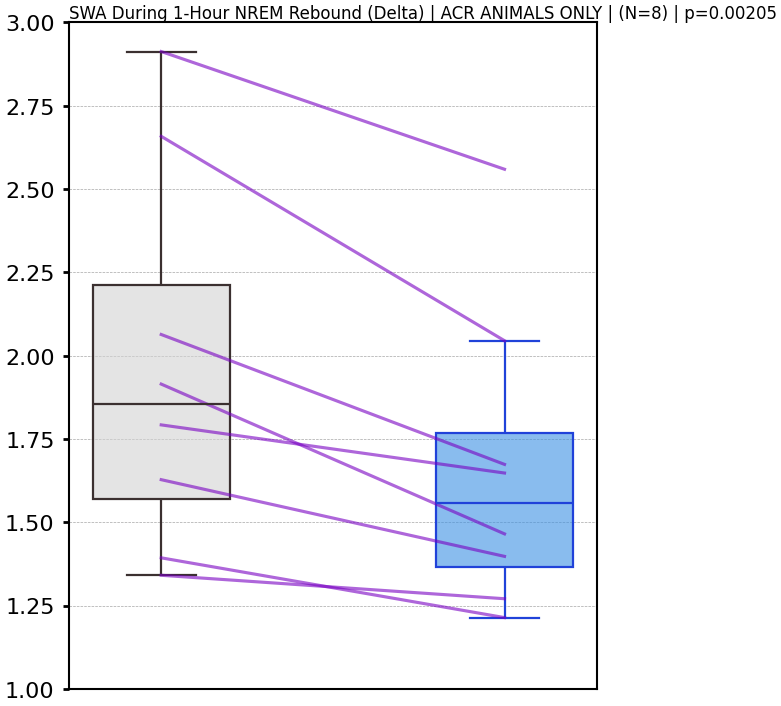

In [8]:
f, ax = plt.subplots(1, 1, figsize=(13, 15), sharey=True)

# OFF-INDUCTION
sns.boxplot(
            data=acr_swa.expmt('swi').prb('NNXr'), 
            x='store', y='Bandpower', 
            order=['NNXr', 'NNXo'], 
            palette=['lightgray', 'dodgerblue'], 
            fliersize=0, 
            ax=ax, 
            width=0.4,
            medianprops={"color": "#3b3030", "linewidth": 3.2},
            whiskerprops={"color": "#3b3030", "linewidth": 3.2},
            capprops={"color": "#3b3030", "linewidth": 3.2},
            boxprops={"edgecolor": "#3b3030", "linewidth": 3.2},)

sns.boxplot(
            data=acr_swa.expmt('swi').prb('NNXo'), 
            x='store', y='Bandpower', 
            order=['NNXr', 'NNXo'], 
            palette=['lightgray', 'dodgerblue'], 
            fliersize=0, 
            ax=ax, 
            width=0.4,
            medianprops={"color": "#2042d9", "linewidth": 3.2},
            whiskerprops={"color": "#2042d9", "linewidth": 3.2},
            capprops={"color": "#2042d9", "linewidth": 3.2},
            boxprops={"edgecolor": "#2042d9", "linewidth": 3.2},)

plt.tight_layout()
for patch in ax.patches:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, 0.6))

#sns.swarmplot(data=acr_swa.expmt('swi'), x='store', y='Bandpower', order=['NNXr', 'NNXo'], palette=['#202223', 'blue'], marker='o', size=15, ax=ax, alpha=0.4)
#sns.lineplot(data=acr_swa.expmt('swi').sort_values('store', ascending=False), x='store', y='Bandpower', units='subject', estimator=None, color='#0175b9', ax=ax, linewidth=4.5, alpha=0.7)
sns.lineplot(data=acr_swa.expmt('swi').sort_values('store', ascending=False), x='store', y='Bandpower', units='subject', estimator=None, color='#7800c2', ax=ax, linewidth=4.5, alpha=0.6)

ax.set_xticklabels('')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(1, 3.0)
#ax.axhline(1, color='red', linestyle='--', linewidth=4)
num_subs = len(acr_swa.expmt('swi').subject.unique())
ax.set_title(f'SWA During 1-Hour NREM Rebound (Delta) | ACR ANIMALS ONLY | (N={num_subs}) | p={swi_pval}', fontsize=24)

f.savefig('./plots/temp/acr_rebound_swi.png', dpi=300, bbox_inches='tight')


/tmp/ipykernel_90543/1583021861.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipykernel_90543/1583021861.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


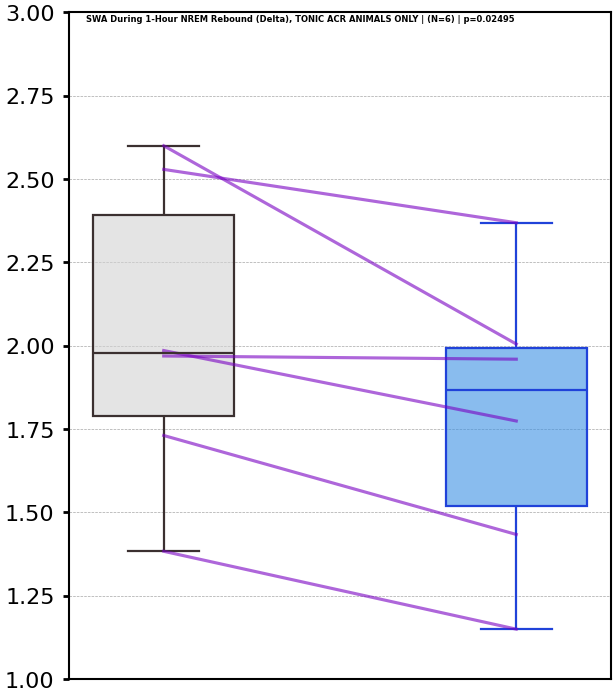

In [10]:
f, ax = plt.subplots(1, 1, figsize=(13, 15), sharey=True)

# OFF-INDUCTION
sns.boxplot(
            data=acr_swa.expmt('swisin').prb('NNXr'), 
            x='store', y='Bandpower', 
            order=['NNXr', 'NNXo'], 
            palette=['lightgray', 'dodgerblue'], 
            fliersize=0, 
            ax=ax, 
            width=0.4,
            medianprops={"color": "#3b3030", "linewidth": 3.2},
            whiskerprops={"color": "#3b3030", "linewidth": 3.2},
            capprops={"color": "#3b3030", "linewidth": 3.2},
            boxprops={"edgecolor": "#3b3030", "linewidth": 3.2},)

sns.boxplot(
            data=acr_swa.expmt('swisin').prb('NNXo'), 
            x='store', y='Bandpower', 
            order=['NNXr', 'NNXo'], 
            palette=['lightgray', 'dodgerblue'], 
            fliersize=0, 
            ax=ax, 
            width=0.4,
            medianprops={"color": "#2042d9", "linewidth": 3.2},
            whiskerprops={"color": "#2042d9", "linewidth": 3.2},
            capprops={"color": "#2042d9", "linewidth": 3.2},
            boxprops={"edgecolor": "#2042d9", "linewidth": 3.2},)

plt.tight_layout()
for patch in ax.patches:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, 0.6))

#sns.swarmplot(data=acr_swa.expmt('swisin'), x='store', y='Bandpower', order=['NNXr', 'NNXo'], palette=['#202223', 'blue'], marker='o', size=15, ax=ax, alpha=0.4)
sns.lineplot(data=acr_swa.expmt('swisin').sort_values('store', ascending=False), x='store', y='Bandpower', units='subject', estimator=None, color='#7800c2', ax=ax, linewidth=4.5, alpha=0.6)

ax.set_xticklabels('')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(1.0, 3.0)
#ax.axhline(1, color='red', linestyle='--', linewidth=4)
num_subs = len(acr_swa.expmt('swisin').subject.unique())
f.suptitle(f'SWA During 1-Hour NREM Rebound (Delta), TONIC ACR ANIMALS ONLY | (N={num_subs}) | p={swisin_pval}', fontsize=12)

f.savefig('./plots/temp/acr_rebound_swisin.png', dpi=300, bbox_inches='tight')

### SOM-ChR2

In [11]:
delta_som = reb_df.loc[reb_df['Band']=='delta'].loc[reb_df['state']=='NREM'].loc[reb_df['exp_type']=='som']
delta_som_means = delta_som.groupby(['subject', 'exp', 'store'])['Bandpower'].mean().to_frame().reset_index().sort_values('Bandpower')
som_swa = delta_som_means.exp_names()

In [12]:
# Statistical tests
# -----------------

delta_reb_swi_nnxr = som_swa.prb('NNXr').expmt('swi').sort_values('subject')['Bandpower'].to_numpy()
delta_reb_swi_nnxo = som_swa.prb('NNXo').expmt('swi').sort_values('subject')['Bandpower'].to_numpy()

delta_reb_swisin_nnxr = som_swa.prb('NNXr').expmt('swisin').sort_values('subject')['Bandpower'].to_numpy()
delta_reb_swisin_nnxo = som_swa.prb('NNXo').expmt('swisin').sort_values('subject')['Bandpower'].to_numpy()

swi_stats = pg.ttest(delta_reb_swi_nnxr, delta_reb_swi_nnxo, paired=True)
swisin_stats = pg.ttest(delta_reb_swisin_nnxr, delta_reb_swisin_nnxo, paired=True)

swi_pval = round(swi_stats['p-val'][0], 5)
swisin_pval = round(swisin_stats['p-val'][0], 5)
print(f'swi p-value = {swi_pval}')
print(f'swisin p-value = {swisin_pval}')

swi p-value = 0.01311
swisin p-value = 0.76132


In [13]:
# Relative statistics (SWI vs. SWISIN)
# This is not super useful/important (as of 2/21/24)
swi_rels = {}
for subject in som_swa.expmt('swi')['subject'].unique():
    swa_rel = som_swa.loc[som_swa['subject']==subject].expmt('swi').prb('NNXo')['Bandpower'].values[0] / som_swa.loc[som_swa['subject']==subject].expmt('swi').prb('NNXr')['Bandpower'].values[0]
    swi_rels[subject] = swa_rel
swisin_rels = {}
for subject in som_swa.expmt('swisin')['subject'].unique():
    swa_rel = som_swa.loc[som_swa['subject']==subject].expmt('swisin').prb('NNXo')['Bandpower'].values[0] / som_swa.loc[som_swa['subject']==subject].expmt('swisin').prb('NNXr')['Bandpower'].values[0]
    swisin_rels[subject] = swa_rel
swi_rels_array = np.array(list(swi_rels.values()))
swisin_rels_array = np.array(list(swisin_rels.values()))
cross_exp_stats = pg.ttest(swi_rels_array, swisin_rels_array, paired=False)
cross_exp_stats

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.69032,2.230827,two-sided,0.554813,"[-0.49, 0.35]",0.650607,0.611,0.117644


/tmp/ipykernel_90543/1559818643.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipykernel_90543/1559818643.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


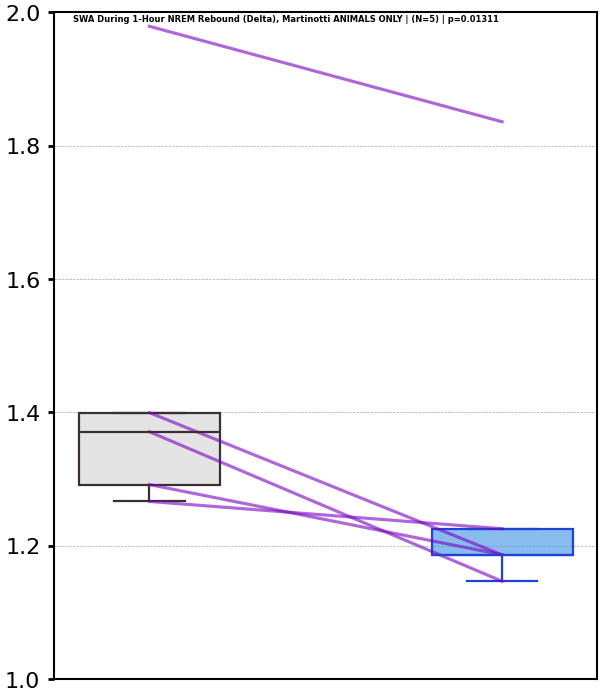

In [16]:
f, ax = plt.subplots(1, 1, figsize=(13, 15), sharey=True)

# OFF-INDUCTION
sns.boxplot(
            data=som_swa.expmt('swi').prb('NNXr'), 
            x='store', y='Bandpower', 
            order=['NNXr', 'NNXo'], 
            palette=['lightgray', 'dodgerblue'], 
            fliersize=0, 
            ax=ax, 
            width=0.4,
            medianprops={"color": "#3b3030", "linewidth": 3.2},
            whiskerprops={"color": "#3b3030", "linewidth": 3.2},
            capprops={"color": "#3b3030", "linewidth": 3.2},
            boxprops={"edgecolor": "#3b3030", "linewidth": 3.2},)

sns.boxplot(
            data=som_swa.expmt('swi').prb('NNXo'), 
            x='store', y='Bandpower', 
            order=['NNXr', 'NNXo'], 
            palette=['lightgray', 'dodgerblue'], 
            fliersize=0, 
            ax=ax, 
            width=0.4,
            medianprops={"color": "#2042d9", "linewidth": 3.2},
            whiskerprops={"color": "#2042d9", "linewidth": 3.2},
            capprops={"color": "#2042d9", "linewidth": 3.2},
            boxprops={"edgecolor": "#2042d9", "linewidth": 3.2},)

plt.tight_layout()
for patch in ax.patches:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, 0.6))

#sns.swarmplot(data=som_swa.expmt('swi'), x='store', y='Bandpower', order=['NNXr', 'NNXo'], palette=['#202223', 'blue'], marker='o', size=15, ax=ax, alpha=0.4)
sns.lineplot(data=som_swa.expmt('swi').sort_values('store', ascending=False), x='store', y='Bandpower', units='subject', estimator=None, color='#7800c2', ax=ax, linewidth=4.5, alpha=0.6)

ax.set_xticklabels('')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(1, 2.0)
#ax.axhline(1, color='red', linestyle='--', linewidth=4)
num_subs = len(som_swa.expmt('swi').subject.unique())
f.suptitle(f'SWA During 1-Hour NREM Rebound (Delta), Martinotti ANIMALS ONLY | (N={num_subs}) | p={swi_pval}', fontsize=12)

f.savefig('./plots/temp/martinotti_rebound_swi.png', dpi=300, bbox_inches='tight')

/tmp/ipykernel_90543/1089828215.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipykernel_90543/1089828215.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


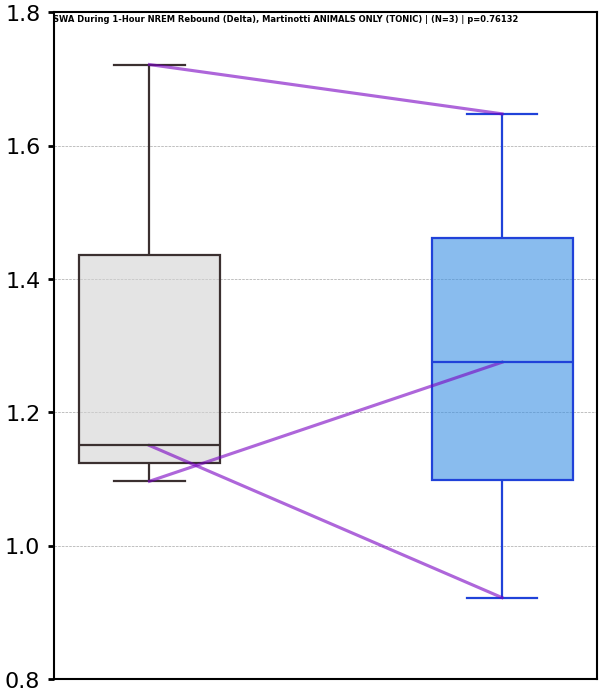

In [26]:
f, ax = plt.subplots(1, 1, figsize=(13, 15), sharey=True)

# OFF-INDUCTION
sns.boxplot(
            data=som_swa.expmt('swisin').prb('NNXr'), 
            x='store', y='Bandpower', 
            order=['NNXr', 'NNXo'], 
            palette=['lightgray', 'dodgerblue'], 
            fliersize=0, 
            ax=ax, 
            width=0.4,
            medianprops={"color": "#3b3030", "linewidth": 3.2},
            whiskerprops={"color": "#3b3030", "linewidth": 3.2},
            capprops={"color": "#3b3030", "linewidth": 3.2},
            boxprops={"edgecolor": "#3b3030", "linewidth": 3.2},)

sns.boxplot(
            data=som_swa.expmt('swisin').prb('NNXo'), 
            x='store', y='Bandpower', 
            order=['NNXr', 'NNXo'], 
            palette=['lightgray', 'dodgerblue'], 
            fliersize=0, 
            ax=ax, 
            width=0.4,
            medianprops={"color": "#2042d9", "linewidth": 3.2},
            whiskerprops={"color": "#2042d9", "linewidth": 3.2},
            capprops={"color": "#2042d9", "linewidth": 3.2},
            boxprops={"edgecolor": "#2042d9", "linewidth": 3.2},)

plt.tight_layout()
for patch in ax.patches:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, 0.6))

#sns.swarmplot(data=som_swa.expmt('swisin'), x='store', y='Bandpower', order=['NNXr', 'NNXo'], palette=['#202223', 'blue'], marker='o', size=15, ax=ax, alpha=0.4)
sns.lineplot(data=som_swa.expmt('swisin').sort_values('store', ascending=False), x='store', y='Bandpower', units='subject', estimator=None, color='#7800c2', ax=ax, linewidth=4.5, alpha=0.6)

ax.set_xticklabels('')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(0.8, 1.8)
#ax.axhline(1, color='red', linestyle='--', linewidth=4)
num_subs = len(som_swa.expmt('swisin').subject.unique())
f.suptitle(f'SWA During 1-Hour NREM Rebound (Delta), Martinotti ANIMALS ONLY (TONIC) | (N={num_subs}) | p={swisin_pval}', fontsize=12)

f.savefig('./plots/temp/martinotti_rebound_swisin.png', dpi=300, bbox_inches='tight')

### Layer-specific

/tmp/ipykernel_90543/162516930.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipykernel_90543/162516930.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipykernel_90543/162516930.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipykernel_90543/162516930.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipykernel_90543/162516930.py:2: FutureWarning: 

Pass

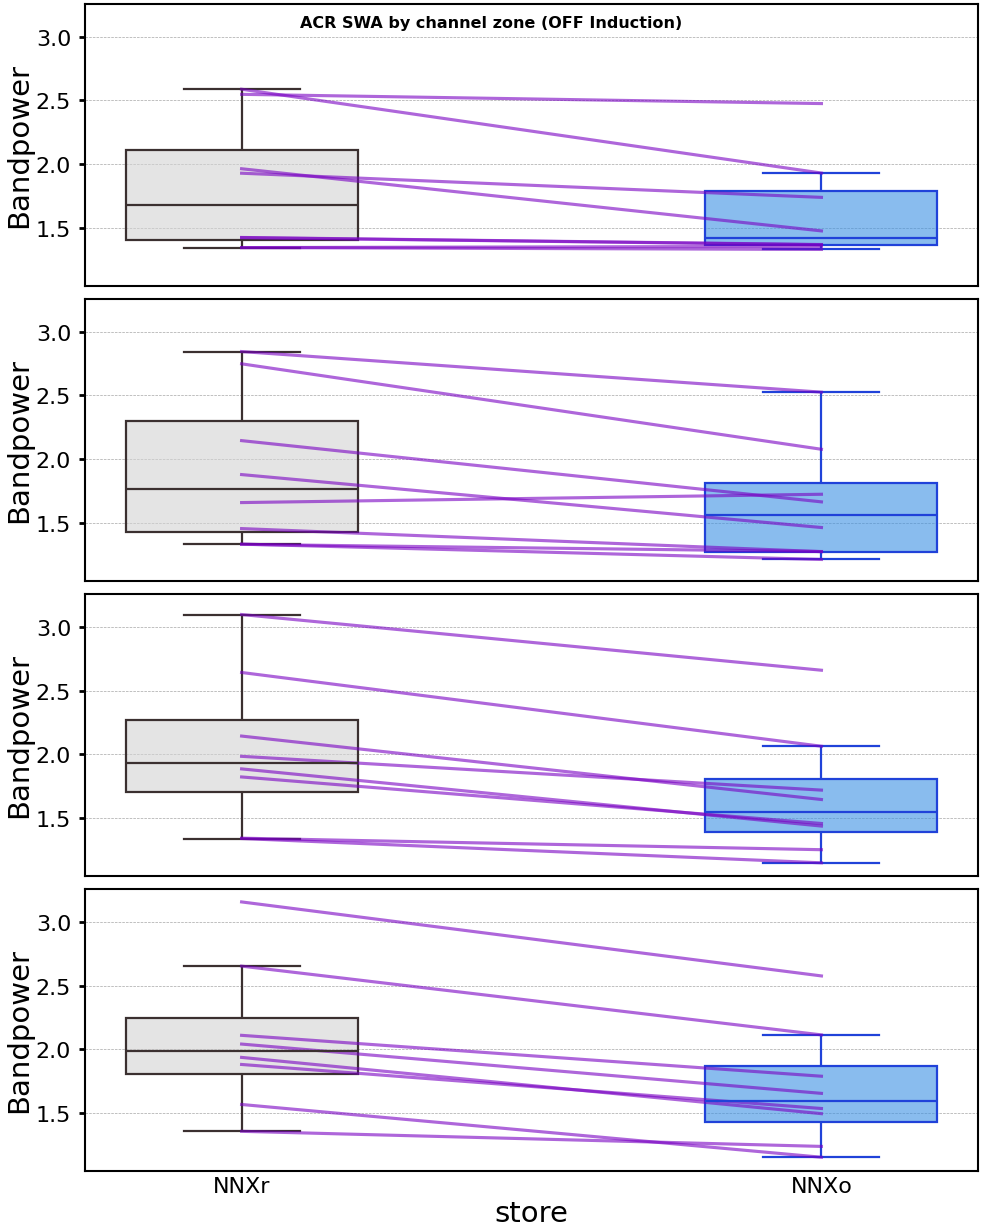

In [46]:
f, ax = plt.subplots(4, 1, figsize=(20, 25), sharex=True, sharey=True)
ax[0] = reb_plot(acr_swa_zones.loc[acr_swa_zones['zone']=='chans_1-4'], 'swi', ax[0])
ax[1] = reb_plot(acr_swa_zones.loc[acr_swa_zones['zone']=='chans_5-8'], 'swi', ax[1])
ax[2] = reb_plot(acr_swa_zones.loc[acr_swa_zones['zone']=='chans_9-12'], 'swi', ax[2])
ax[3] = reb_plot(acr_swa_zones.loc[acr_swa_zones['zone']=='chans_13-16'], 'swi', ax[3])
f.suptitle('ACR SWA by channel zone (OFF Induction)')
f.savefig('./plots/temp/acr_rebound_swi_zones.png', dpi=300, bbox_inches='tight')

/tmp/ipykernel_90543/162516930.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipykernel_90543/162516930.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipykernel_90543/162516930.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipykernel_90543/162516930.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipykernel_90543/162516930.py:2: FutureWarning: 

Pass

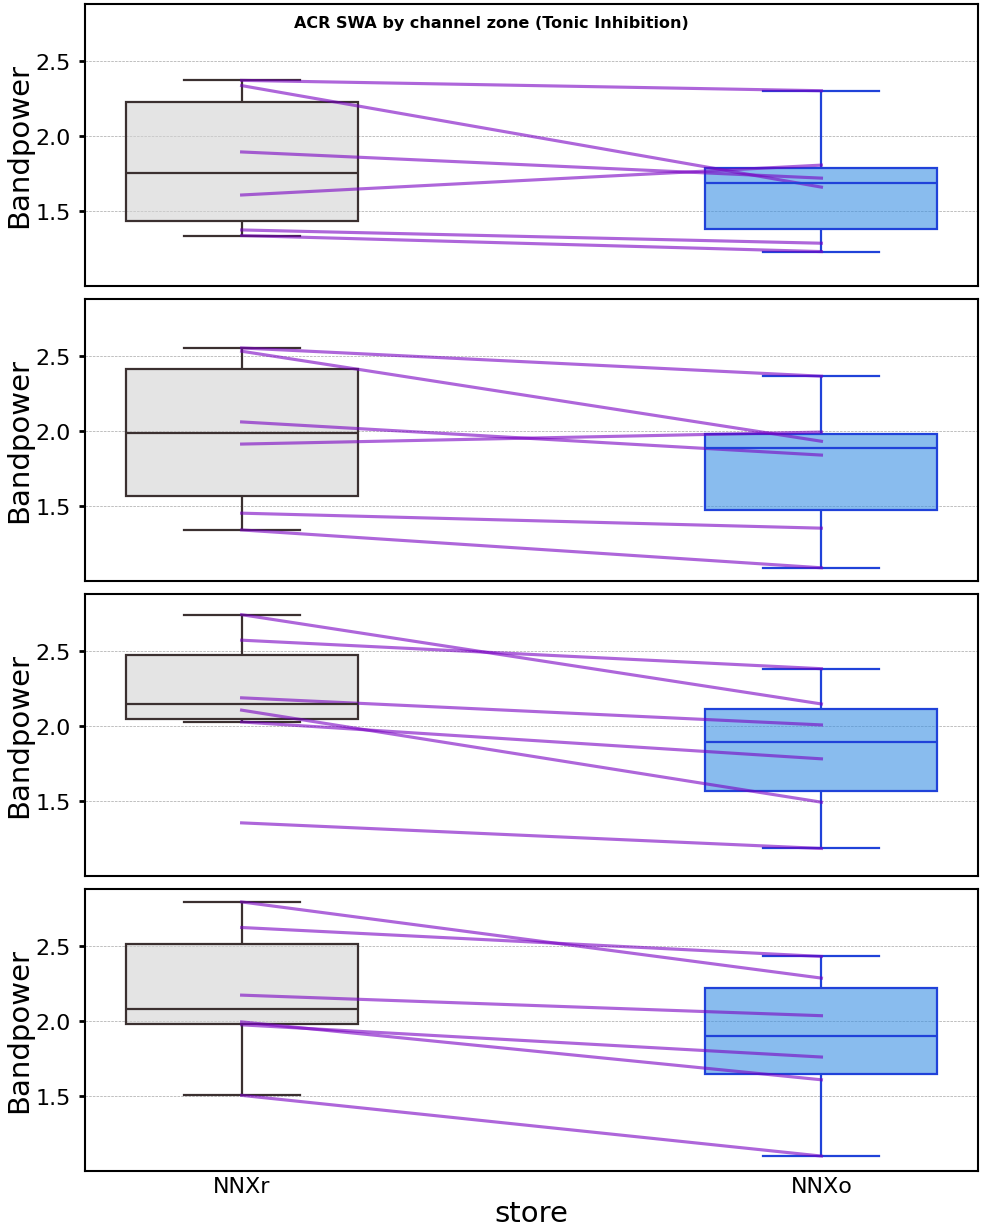

In [47]:
f, ax = plt.subplots(4, 1, figsize=(20, 25), sharex=True, sharey=True)
ax[0] = reb_plot(acr_swa_zones.loc[acr_swa_zones['zone']=='chans_1-4'], 'swisin', ax[0])
ax[1] = reb_plot(acr_swa_zones.loc[acr_swa_zones['zone']=='chans_5-8'], 'swisin', ax[1])
ax[2] = reb_plot(acr_swa_zones.loc[acr_swa_zones['zone']=='chans_9-12'], 'swisin', ax[2])
ax[3] = reb_plot(acr_swa_zones.loc[acr_swa_zones['zone']=='chans_13-16'], 'swisin', ax[3])
f.suptitle('ACR SWA by channel zone (Tonic Inhibition)')
f.savefig('./plots/temp/acr_rebound_tonic_zones.png', dpi=300, bbox_inches='tight')

In [13]:
frontal = reb_df.filter(pl.col('region')=='frontal').filter(pl.col('Band')=='delta').st('NREM').filter(pl.col('exp_type')!='control').filter(pl.col('exp')=='swi')
parietal = reb_df.filter(pl.col('region')=='parietal').filter(pl.col('Band')=='delta').st('NREM').filter(pl.col('exp_type')!='control').filter(pl.col('exp')=='swi')

<Axes: xlabel='layer', ylabel='Bandpower'>

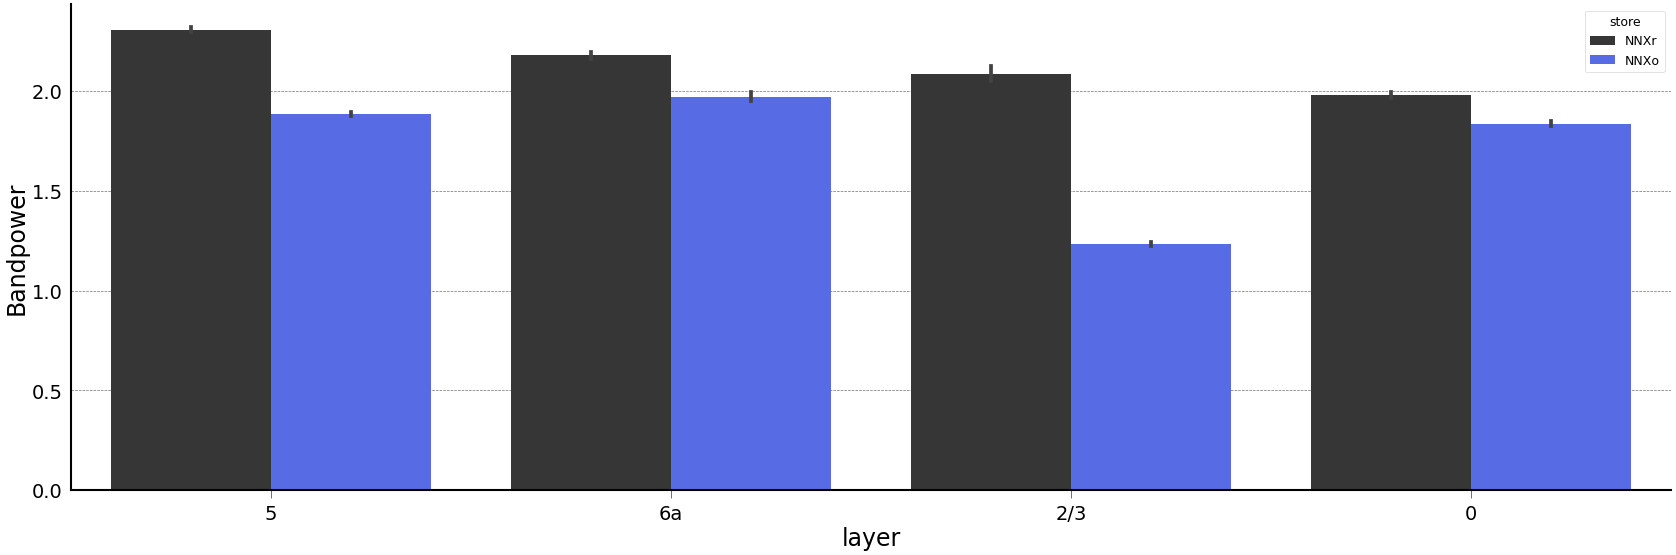

In [18]:
sns.barplot(frontal.to_pandas(), x='layer', y='Bandpower', hue='store')

<Axes: xlabel='layer', ylabel='Bandpower'>

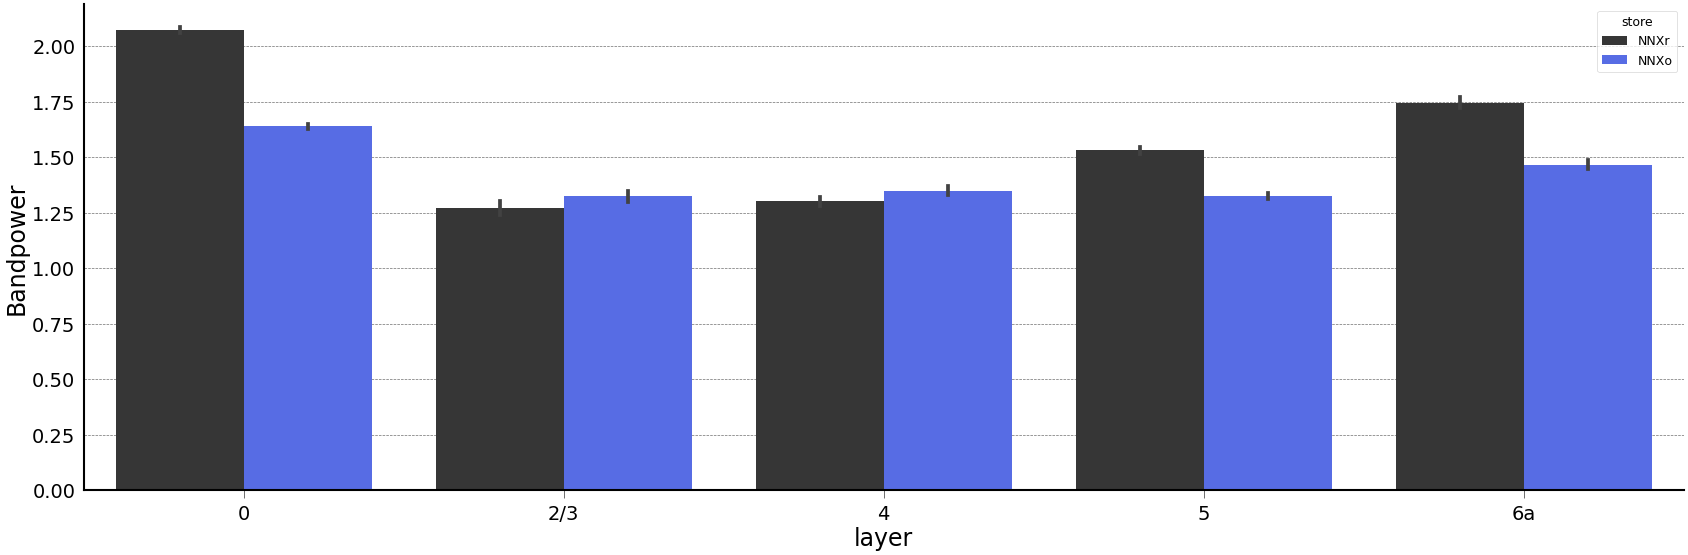

In [20]:
sns.barplot(parietal.to_pandas(), x='layer', y='Bandpower', hue='store')

### Controls

In [241]:
control_acr = reb_df.loc[reb_df['Band']=='delta'].loc[reb_df['state']=='NREM'].loc[reb_df['exp_type']=='control']
control_acr_means = control_acr.groupby(['subject', 'exp', 'store'])['Bandpower'].mean().to_frame().reset_index().sort_values('Bandpower')
control_swa = control_acr_means.exp_names()

In [242]:
# Statistical tests
# -----------------

delta_reb_swi_nnxr = control_swa.prb('NNXr').expmt('swi').sort_values('subject')['Bandpower'].to_numpy()
delta_reb_swi_nnxo = control_swa.prb('NNXo').expmt('swi').sort_values('subject')['Bandpower'].to_numpy()

delta_reb_swisin_nnxr = control_swa.prb('NNXr').expmt('swisin').sort_values('subject')['Bandpower'].to_numpy()
delta_reb_swisin_nnxo = control_swa.prb('NNXo').expmt('swisin').sort_values('subject')['Bandpower'].to_numpy()

swi_stats = pg.ttest(delta_reb_swi_nnxr, delta_reb_swi_nnxo, paired=True)
swisin_stats = pg.ttest(delta_reb_swisin_nnxr, delta_reb_swisin_nnxo, paired=True)

swi_pval = round(swi_stats['p-val'][0], 5)
swisin_pval = round(swisin_stats['p-val'][0], 5)
print(f'swi p-value = {swi_pval}')
print(f'swisin p-value = {swisin_pval}')

swi p-value = 0.79408
swisin p-value = nan


/home/kdriessen/miniconda3/envs/acr/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:7321: RuntimeWarning: divide by zero encountered in _nct_sf
  return np.clip(_boost._nct_sf(x, df, nc), 0, 1)
/home/kdriessen/miniconda3/envs/acr/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:7313: RuntimeWarning: divide by zero encountered in _nct_cdf
  return np.clip(_boost._nct_cdf(x, df, nc), 0, 1)
/home/kdriessen/miniconda3/envs/acr/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1103: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/home/kdriessen/miniconda3/envs/acr/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1103: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/home/kdriessen/miniconda3/envs/acr/lib/python3.11/site-packages/pingouin/parametric.py:243: RuntimeWarning: Degrees of freedom <= 0 for s

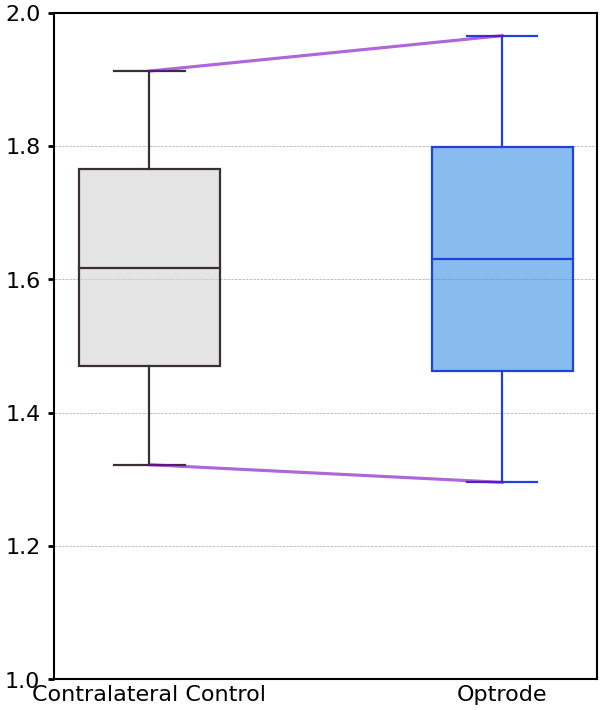

In [248]:
f, ax = plt.subplots(1, 1, figsize=(13, 15), sharey=True)

# OFF-INDUCTION
sns.boxplot(
            data=control_swa.expmt('swi').prb('NNXr'), 
            x='store', y='Bandpower', 
            order=['NNXr', 'NNXo'], 
            palette=['lightgray', 'dodgerblue'], 
            fliersize=0, 
            ax=ax, 
            width=0.4,
            medianprops={"color": "#3b3030", "linewidth": 3.2},
            whiskerprops={"color": "#3b3030", "linewidth": 3.2},
            capprops={"color": "#3b3030", "linewidth": 3.2},
            boxprops={"edgecolor": "#3b3030", "linewidth": 3.2},)

sns.boxplot(
            data=control_swa.expmt('swi').prb('NNXo'), 
            x='store', y='Bandpower', 
            order=['NNXr', 'NNXo'], 
            palette=['lightgray', 'dodgerblue'], 
            fliersize=0, 
            ax=ax, 
            width=0.4,
            medianprops={"color": "#2042d9", "linewidth": 3.2},
            whiskerprops={"color": "#2042d9", "linewidth": 3.2},
            capprops={"color": "#2042d9", "linewidth": 3.2},
            boxprops={"edgecolor": "#2042d9", "linewidth": 3.2},)

plt.tight_layout()
for patch in ax.patches:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, 0.6))

#sns.swarmplot(data=control_swa.expmt('swi'), x='store', y='Bandpower', order=['NNXr', 'NNXo'], palette=['#202223', 'blue'], marker='o', size=15, ax=ax, alpha=0.4)
sns.lineplot(data=control_swa.expmt('swi').sort_values('store', ascending=False), x='store', y='Bandpower', units='subject', estimator=None, color='#7800c2', ax=ax, linewidth=4.5, alpha=0.6)

ax.set_xticklabels(['Contralateral Control', 'Optrode'])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(1, 2.0)
#ax.axhline(1, color='red', linestyle='--', linewidth=4)
num_subs = len(control_swa.expmt('swi').subject.unique())
#f.suptitle(f'SWA During 1-Hour NREM Rebound (Delta), Martinotti ANIMALS ONLY | (N={num_subs}) | p={swi_pval}', fontsize=12)

f.savefig('./plots/control_rebound_swi.png', dpi=300, bbox_inches='tight')

## All Bands

In [51]:
reb_df = acr.io.read_full_df(folder='rebound_data_1h', method='polars')

In [53]:
bp_exp_means

subject,Band,exp,store,datetime,channel,state,Bandpower,region,exp_type,layer
str,str,str,str,datetime[ns],f64,str,f32,str,str,str
"""ACR_17""","""low_gamma""","""swi""","""NNXo""",2022-12-05 14:46:33.562811648,8.5,null,0.338123,null,null,null
"""ACR_17""","""low_gamma""","""swi""","""NNXr""",2022-12-05 14:46:33.562811648,8.5,null,0.386333,null,null,null
"""ACR_17""","""high_gamma""","""swi""","""NNXr""",2022-12-05 14:46:33.562811648,8.5,null,0.443838,null,null,null
"""ACR_17""","""high_gamma""","""swi""","""NNXo""",2022-12-05 14:46:33.562811648,8.5,null,0.449594,null,null,null
"""ACR_23""","""low_gamma""","""swisin""","""NNXo""",2023-07-21 14:46:21.024673792,8.5,null,0.769202,null,null,null
…,…,…,…,…,…,…,…,…,…,…
"""ACR_20""","""delta""","""swi""","""NNXr""",2023-02-27 14:27:38.281334784,8.5,null,2.658054,null,null,null
"""ACR_18""","""delta1""","""swisin""","""NNXr""",2023-01-11 14:40:27.549448448,8.5,null,2.826853,null,null,null
"""ACR_18""","""delta""","""swi""","""NNXr""",2023-01-03 15:01:35.640690944,8.5,null,2.912383,null,null,null


In [54]:
bp_exp = reb_df.st('NREM').filter(pl.col('exp_type')!='control')
bp_exp_means = bp_exp.groupby(['subject', "Band", 'exp', 'store']).mean().sort('Bandpower')
bp_exp_means = bp_exp_means.with_columns(exp_alias=pl.when(pl.col('exp')=='swi2').then(pl.lit('swi')).otherwise(pl.col('exp'))) # this is an alias so that the swi2 experiments can be grouped with the swi experimental group
bp_exp_means = bp_exp_means.to_pandas()

# Need to do this so I can connect the individual data points within experiments, each two data points need their own subject number
sub_array = bp_exp_means['subject']
bp_exp_means['sub_alias'] = sub_array
for subject in bp_exp_means.expmt('swi2').subject.unique():
    bp_exp_means.loc[(bp_exp_means.subject == subject) & (bp_exp_means['exp'] == 'swi2'), 'sub_alias'] = f'{subject}_b'

/tmp/ipykernel_90543/3432225926.py:2: DeprecationWarning: `groupby` is deprecated. It has been renamed to `group_by`.
  bp_exp_means = bp_exp.groupby(['subject', "Band", 'exp', 'store']).mean().sort('Bandpower')


(0.0, 3.5)

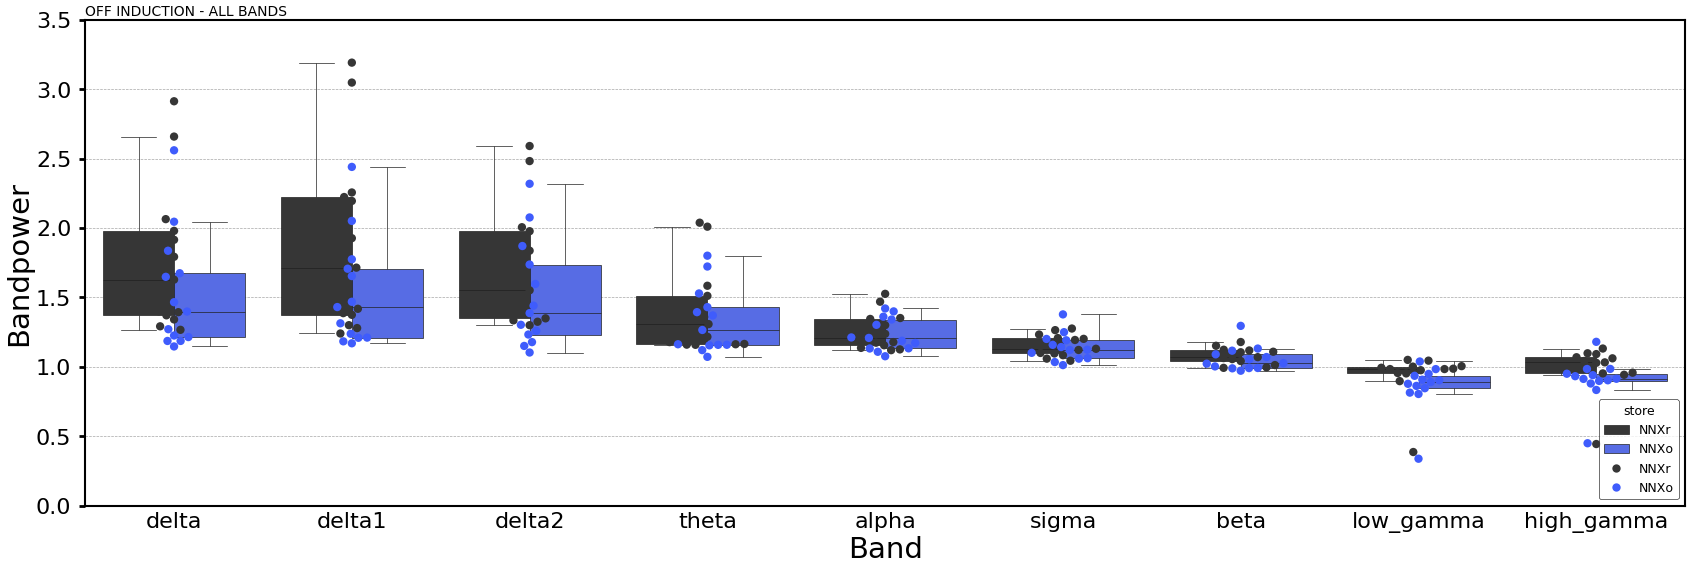

In [55]:
f, ax = plt.subplots()
sns.boxplot(data=bp_exp_means.exp_als('swi'), x='Band', y='Bandpower', hue='store', order=band_def, hue_order=['NNXr', 'NNXo'], fliersize=0, ax=ax)
sns.swarmplot(data=bp_exp_means.exp_als('swi'), x='Band', y='Bandpower', hue='store', order=band_def, hue_order=['NNXr', 'NNXo'], marker='o', size=12, ax=ax)
ax.set_title('OFF INDUCTION - ALL BANDS')
ax.set_ylim(0, 3.5)

(0.0, 3.5)

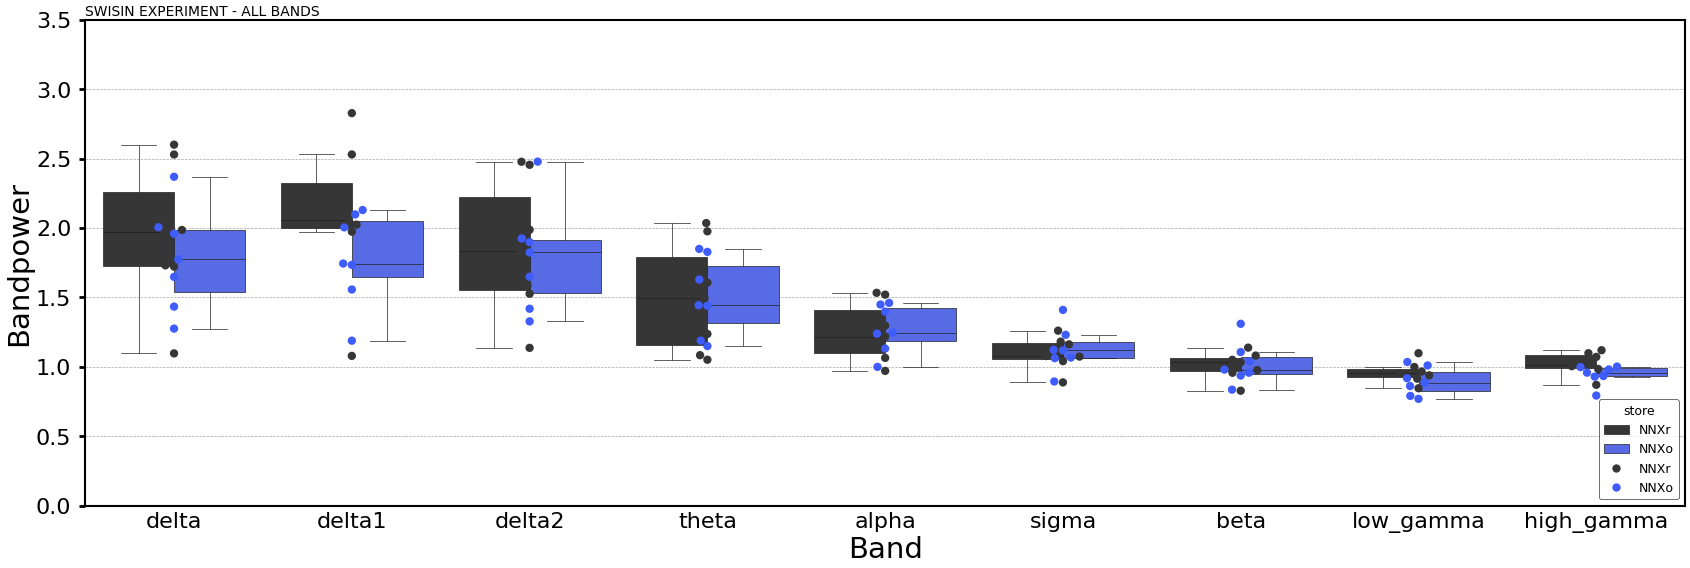

In [56]:
f, ax = plt.subplots()
sns.boxplot(data=bp_exp_means.exp_als('swisin'), x='Band', y='Bandpower', hue='store', order=band_def, hue_order=['NNXr', 'NNXo'], fliersize=0, ax=ax)
sns.swarmplot(data=bp_exp_means.exp_als('swisin'), x='Band', y='Bandpower', hue='store', order=band_def, hue_order=['NNXr', 'NNXo'], marker='o', size=12, ax=ax)
ax.set_title('SWISIN EXPERIMENT - ALL BANDS')
ax.set_ylim(0, 3.5)